In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# hyper params initalization
_batch_size = 128
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_lr_rate = 0.01
_momentum = 0.9
_epoch = 50

In [2]:
# load MNIST data set into data loader
mnist_train = datasets.MNIST("./data", train=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False,  transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = _batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = _batch_size, shuffle=True)

In [19]:
avoid_zero_div = 1e-12

class pgd_rand(object):
    """ PGD attacks, with random initialization within the specified lp ball """
    def __init__(self, **kwargs):
        # define default attack parameters here:
        self.param = {'ord': np.inf,
                      'epsilon': 0.3,
                      'alpha': 0.01,
                      'num_iter': 40,
                      'restarts': 1,
                      'loss_fn': nn.CrossEntropyLoss()}
        # parse thru the dictionary and modify user-specific params
        self.parse_param(**kwargs) 
        
    def generate(self, model, x, y):
        epsilon = self.param['epsilon']
        alpha = self.param['alpha']
        num_iter = self.param['num_iter']
        restarts = self.param['restarts']
        loss_fn = self.param['loss_fn']
        p_norm = self.param['ord'] 
        
        # implementation begins:
        max_loss = torch.zeros(y.shape[0]).to(y.device)
        max_delta = torch.zeros_like(x)
        _dim = x.shape[1] * x.shape[2] * x.shape[3]
        
        for i in range(restarts):
            if p_norm == np.inf:
                delta = torch.rand_like(x, requires_grad=True)
                delta.data = delta.data * 2. * epsilon - epsilon
                delta.data = (x.data + delta.data).clamp(min = 0, max = 1.0) - x.data
                for t in range(num_iter):
                    model.zero_grad()
                    loss = loss_fn(model(x + delta), y)
                    loss.backward()
                    # first we need to make sure delta is within the specified lp ball
                    delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(min = -epsilon, max = epsilon)
                    # then we need to make sure x+delta in the next iteration is within the [0,1] range
                    delta.data = (x.data + delta.data).clamp(min = 0, max = 1.) - x.data
                    delta.grad.zero_()
            
            # added the if condition to cut 1 additional unnecessary foward pass
            if restarts > 1:
                all_loss = nn.CrossEntropyLoss(reduction='none')(model(x+delta),y)
                max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
                max_loss = torch.max(max_loss, all_loss)
            else:
                max_delta = delta.detach()
        return max_delta

    def parse_param(self, **kwargs):
        for key,value in kwargs.items():
            if key in self.param:
                self.param[key] = value


In [3]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 28, 1, bias = False)
        torch.nn.init.xavier_uniform(self.conv1.weight)

    def forward(self, x):
        
        output = self.conv1(x)
        return output

In [10]:
def one_epoch(model, device, loader, opt, train = True, adv = False):
    total_correct = 0
    if train:
        model.train()
    else:
        model.eval()

    with trange(len(loader)) as t:
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            opt.zero_grad()

            if adv:
                delta = pgd_rand().generate(model,X,y)
                yp = model(X+delta)
                loss = nn.CrossEntropyLoss()(yp,y)

            else:
                yp = model(X)
                loss = nn.CrossEntropyLoss()(yp,y)

            # ipdb.set_trace()

            if train:
                loss.backward()
                opt.step()

            # ipdb.set_trace()
            batch_correct = ((yp>0) == y).sum().item()
            total_correct += batch_correct
            batch_acc = batch_correct / X.shape[0]
            # total_loss_adv += loss_adv.item() * X.shape[0]

            t.set_postfix(loss = loss.item(), 
                        batch_acc = '{0:.2f}%'.format(batch_acc*100), 
                        total_acc = '{0:.2f}%'.format(total_correct/loader.dataset.data.shape[0]*100))
            t.update()

In [11]:
model = Net2().to(_device)
# mask_weight(model, 13, device)
# init_weight = list(model.parameters())[0].data.view(28,28).detach().cpu().numpy()


opt = optim.SGD(model.parameters(), lr=_lr_rate)

for epoch in range(1, _epoch + 1):
    one_epoch(model, _device, train_loader, opt, train = True, adv = False)

/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
  0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: 1only batches of spatial targets supported (non-empty 3D tensors) but got targets of size: : [128]

In [9]:
# specifying model and optimizer
_model_adv = l2().to(_device)
_model_path = './weight/binary_mnist_l2_adv_20190813_152501.pt'
_model_adv.load_state_dict(torch.load(_model_path, map_location = _device))
_model_adv.to(_device)
_model_adv.eval()

# specifying model and optimizer
_model_H = l2().to(_device)
_model_path = './weight/binary_mnist_l2_H_20190820_165101.pt'
_model_H.load_state_dict(torch.load(_model_path, map_location = _device))
_model_H.to(_device)
_model_H.eval()

# label 0: 3, label 1: 7 
weight_adv = list(_model_adv.parameters())[0]
bias_adv = list(_model_adv.parameters())[1]
weight_H = list(_model_H.parameters())[0]
bias_H = list(_model_H.parameters())[1]

Text(0.5, 0, '||w||_1 = 9.73')

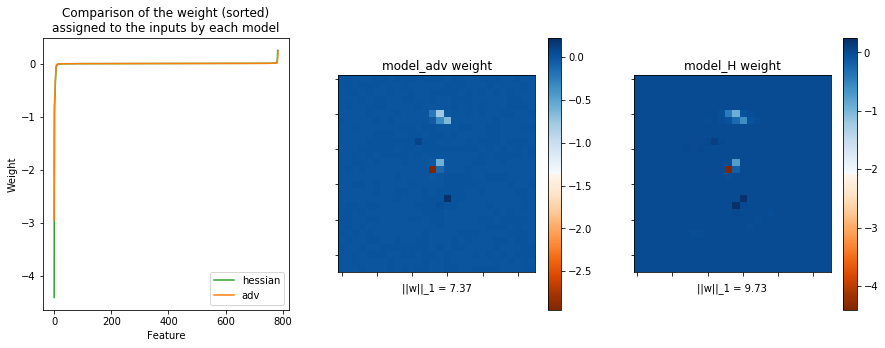

In [14]:
fig_test = plt.figure(figsize = [15,5])
gs = fig_test.add_gridspec(1,3)
fig_test.add_subplot(gs[0,0]).plot(weight_H.squeeze().sort()[0].detach().cpu().numpy(),color = 'C2',label = 'hessian')


fig_test.add_subplot(gs[0,0]).plot(weight_adv.squeeze().sort()[0].detach().cpu().numpy(),color = 'C1',label = 'adv')
fig_test.add_subplot(gs[0,0]).set_title('Comparison of the weight (sorted)\nassigned to the inputs by each model')
fig_test.add_subplot(gs[0,0]).legend()
fig_test.add_subplot(gs[0,0]).set_xlabel('Feature')
fig_test.add_subplot(gs[0,0]).set_ylabel('Weight')


# blue: positive, red: negative
top = plt.cm.get_cmap('Oranges_r', 128)
bottom = plt.cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = colors.ListedColormap(newcolors, name='OrangeBlue')

# p2 = fig_test.add_subplot(gs[1,2]).imshow(weight_adv.view(28,28).cpu().detach().numpy(),cmap = newcmp, vmin = -1, vmax = 1)
p2 = fig_test.add_subplot(gs[0,1]).imshow(weight_adv.view(28,28).cpu().detach().numpy(),cmap = newcmp)
fig_test.colorbar(p2)
fig_test.add_subplot(gs[0,1]).set_yticklabels([])
fig_test.add_subplot(gs[0,1]).set_xticklabels([])

# p4 = fig_test.add_subplot(gs[1,3]).imshow(weight_H.view(28,28).cpu().detach().numpy(),cmap = newcmp, vmin = -1, vmax = 1)
p4 = fig_test.add_subplot(gs[0,2]).imshow(weight_H.view(28,28).cpu().detach().numpy(),cmap = newcmp)
fig_test.colorbar(p4)
fig_test.add_subplot(gs[0,2]).set_yticklabels([])
fig_test.add_subplot(gs[0,2]).set_xticklabels([])

fig_test.add_subplot(gs[0,1]).set_title('model_adv weight')
fig_test.add_subplot(gs[0,2]).set_title('model_H weight')
fig_test.add_subplot(gs[0,1]).set_xlabel('||w||_1 = {0:.2f}'.format(weight_adv.abs().sum().item()))
fig_test.add_subplot(gs[0,2]).set_xlabel('||w||_1 = {0:.2f}'.format(weight_H.abs().sum().item()))

In [16]:
for X,y in train_loader:
    X,y = X.to(_device), y.to(_device)
    break
diff = torch.mean(X[y==1,:,:,:], dim=0).squeeze() - torch.mean(X[y==0,:,:,:], dim=0).squeeze()
total_loss, total_correct = 0.,0.

for X,y in test_loader:
    X,y = X.to(_device), y.to(_device).float()
    yp = nn.Sigmoid()(torch.matmul(diff.view(1,784), X.view(X.shape[0],784,1)).view(X.shape[0]))
    total_correct += ((yp.squeeze()>0.5).float() == y.squeeze().float()).sum().item()
#     total_loss += loss.item() * X.shape[0]
acc = total_correct / len(test_loader.dataset)

print(acc*100)


95.09322865554465
